# Implementation

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
plt.style.use('dark_background')

In [3]:
import sklearn
import keras
import tensorflow as tf

In [4]:
from keras.applications import InceptionV3

In [5]:
!pip install opencv-python==4.5.5.64

In [6]:
import cv2

## Exploratory Analysis

In [7]:
path = os.getcwd()
path = path[:-4]
data_dir = path + "/data/lfw-deepfunneled"

In [8]:
len(os.listdir(data_dir))

5750

Should be 5750 people.

In [9]:
people = pd.read_csv(path + "/data/people.csv")

In [10]:
people

,name,images
0,Abdel_Madi_Shabneh,1.0
1,Abdul_Rahman,1.0
2,Abel_Pacheco,4.0
3,Adriana_Lima,1.0
4,Afton_Smith,1.0
...,...,...
5753,Yves_Brodeur,1.0
5754,Zach_Pillar,1.0
5755,Zafarullah_Khan_Jamali,2.0
5756,Zara_Akhmadova,1.0


5758 people in metadata spreadsheet... let's consider only the intersection.

In [11]:
names = [item for item in people["name"].tolist() if item in os.listdir(data_dir)]

In [12]:
len(names)

5749

In [13]:
people = people[people["name"].isin(names)]

In [14]:
people

,name,images
0,Abdel_Madi_Shabneh,1.0
1,Abdul_Rahman,1.0
2,Abel_Pacheco,4.0
3,Adriana_Lima,1.0
4,Afton_Smith,1.0
...,...,...
5753,Yves_Brodeur,1.0
5754,Zach_Pillar,1.0
5755,Zafarullah_Khan_Jamali,2.0
5756,Zara_Akhmadova,1.0


In [15]:
people["images"].sum()

13233.0

In [16]:
people[people["images"] > 1]

,name,images
2,Abel_Pacheco,4.0
6,Akhmed_Zakayev,3.0
10,Alejandro_Atchugarry,2.0
17,Amber_Tamblyn,2.0
19,Anders_Fogh_Rasmussen,4.0
...,...,...
5738,Vladimir_Voltchkov,2.0
5740,Wang_Yi,2.0
5742,William_Burns,2.0
5755,Zafarullah_Khan_Jamali,2.0


1680 people with more than 1 image. Will use for test.

Let's get the pixel matrix of an image and plot it.

In [17]:
image_path = data_dir + '/' + names[1] + '/' + names[1] + '_0001.jpg'

In [18]:
image = cv2.imread(image_path)

In [19]:
image.shape

(250, 250, 3)

250 x 250 pixel image with 3 color channels

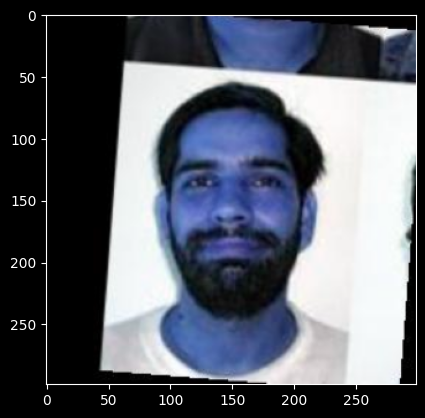

In [20]:
test_image = cv2.resize(image, (299, 299))
plt.imshow(test_image)
plt.axis()
plt.show()

In [21]:
test_image = tf.expand_dims(test_image, axis=0)

In [22]:
test_image.shape

TensorShape([1, 299, 299, 3])

## Model Architecture

In [23]:
inceptionv3 = InceptionV3()
# inceptionv3.summary()

In [24]:
model = InceptionV3(include_top=False, classes=5749, pooling='avg', weights='imagenet')

In [25]:
# add avg_pool and predictions (k=5749) layers
model = keras.Sequential(layers=(model, keras.layers.Dense(5749, activation='softmax')))

In [26]:
np.argmax(model(test_image)[0])

5046

In [27]:
model(test_image)[0][117]

<tf.Tensor: shape=(), dtype=float32, numpy=3.74202e-21>

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (1, 2048)              │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 5749)              │    11,779,701 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,582,485 (128.11 MB)

 Trainable params: 33,548,053 (127.98 MB)

 Non-trainable params: 34,432 (134.50 KB)

## Data Preparation

In [29]:
people = people.rename(columns={'images': 'num_images'})

In [30]:
people = people.set_index('name')

In [31]:
people.head()

,num_images
name,
Abdel_Madi_Shabneh,1.0
Abdul_Rahman,1.0
Abel_Pacheco,4.0
Adriana_Lima,1.0
Afton_Smith,1.0


In [32]:
people[people['num_images'] == people['num_images'].max()]

,num_images
name,
George_W_Bush,530.0


In [33]:
names[:5]

['Abdel_Madi_Shabneh',
 'Abdul_Rahman',
 'Abel_Pacheco',
 'Adriana_Lima',
 'Afton_Smith']

In [34]:
image_col = []
for person in people.iterrows():
    person = person[1]
    image_list = []
    for i in range(int(person["num_images"])):
        image_path = data_dir + '/' + person.name + '/' + person.name + '_' +  "{:04d}".format(i+1) + '.jpg'
        image = cv2.imread(image_path)
        image = cv2.resize(image, (299, 299))
        #image = tf.expand_dims(image, axis=0)
        image_list.append(image)
    image_col.append(image_list)

In [35]:
people["images"] = image_col

In [36]:
# num_images == len(images) for each person
assert ([len(x) for x in people["images"]] == people["num_images"].values).all()

In [37]:
dataset = [] # element: (image, person, train or test)
for person in people.iterrows():
    person = person[1]
    image_list = person["images"]
    num_images = len(image_list)
    for i in range(num_images):
        image = image_list[i]
        element = [image, person.name, "train" if i==0 else "test"]
        dataset.append(element)
dataset = pd.DataFrame(dataset, columns=["image", "person", "split"])

In [38]:
dataset = pd.get_dummies(dataset, columns=['person'])

In [39]:
dataset.head()

,image,split,person_AJ_Cook,person_AJ_Lamas,person_Aaron_Eckhart,person_Aaron_Guiel,person_Aaron_Patterson,person_Aaron_Peirsol,person_Aaron_Pena,person_Aaron_Sorkin,...,person_Zico,person_Zinedine_Zidane,person_Ziwang_Xu,person_Zoe_Ball,person_Zoran_Djindjic,person_Zorica_Radovic,person_Zulfiqar_Ahmed,person_Zumrati_Juma,person_Zurab_Tsereteli,person_Zydrunas_Ilgauskas
0,"[[[2, 0, 1], [2, 0, 1], [2, 0, 1], [2, 0, 1], ...",train,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",train,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",train,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",test,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"[[[11, 1, 7], [4, 0, 4], [1, 6, 9], [1, 6, 10]...",test,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Model Training on LFW Dataset

<img src="fig2.png" alt="drawing" width="600"/><br>
1. Train model using only 1 image of each person.
2. Use remaining images as test dataset, get results.

In [40]:
X_train = dataset[dataset["split"] == "train"]["image"].tolist()
X_train = np.asarray(X_train).astype('float32')
X_test = dataset[dataset["split"] == "test"]["image"].tolist()
X_test = np.asarray(X_test).astype('float32')

In [41]:
y_train = dataset[dataset["split"] == "train"].drop(['image', 'split'], axis=1)
y_test = dataset[dataset["split"] == "test"].drop(['image', 'split'], axis=1)

In [42]:
model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])

In [43]:
model.fit(X_train, y_train, shuffle=False, epochs=10)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1233s 7s/step - accuracy: 0.0000e+00 - loss: 8.7398
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1384s 8s/step - accuracy: 7.3870e-04 - loss: 8.2548
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 4401s 25s/step - accuracy: 0.0000e+00 - loss: 8.4024
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 2578s 14s/step - accuracy: 0.0000e+00 - loss: 8.3766
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1612s 9s/step - accuracy: 5.5001e-04 - loss: 8.3509
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 3831s 21s/step - accuracy: 0.0000e+00 - loss: 8.3440
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 4041s 23s/step - accuracy: 0.0000e+00 - loss: 8.4918
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 7166s 40s/step - accuracy: 0.0011 - loss: 8.3991
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1219s 7s/step - accuracy: 1.6327e-04 - loss: 8.2311
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1257s 7s/step - accuracy: 5.0472e-05 - loss: 7.9106


In [44]:
p = model(tf.expand_dims(X_train[0], axis=0))

In [45]:
np.argmax(p)

1482

In [46]:
np.argmax(y_train.iloc[0])

12

In [47]:
p = model(tf.expand_dims(X_test[0], axis=0))

In [48]:
np.argmax(p)

2754

In [49]:
np.argmax(y_test.iloc[0])

25

Sparsity of data... let's train the model using only samples with num_images > N.